LSTM on past power data to predict power 1, 2 and 3 hours ahead

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat
from scipy.stats import norm

# Import pytorch utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
#matplotlib notebook
plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams['figure.figsize'] = (12, 8)
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20
plt.rcParams['text.usetex'] = False
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE , frameon = True, fancybox = True, loc = 'lower left')    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
diri="../../Kaggle Data/" # ""
x_train = pd.read_csv(diri+'windforecasts_wf1.csv', index_col='date')
y_train = pd.read_csv(diri+'train.csv')
# just consider the wind farm 1
x_train.index = pd.to_datetime(x_train.index, format= '%Y%m%d%H')
x_train['time'] = x_train.index + pd.to_timedelta(x_train.hors,"H")

In [4]:
y_train['date'] = pd.to_datetime(y_train.date, format= '%Y%m%d%H')
y_train.index = y_train['date'] 
y_train.drop('date', inplace = True, axis = 1)

In [5]:
# Select forecast data set
x_train_update = x_train[x_train.hors<=12]
x_train_update = x_train_update[:'2010-12-31 12']

ws= x_train_update.ws.copy().values #used for weibull fitting

maxi=x_train_update[0:int(len(x_train_update)*0.8)+1].ws.max()
mini=x_train_update[0:int(len(x_train_update)*0.8)+1].ws.min()
x_train_update.ws=(x_train_update.ws-mini)/(maxi-mini)

# One hot encode the wind directions
wd_onehot = []

for i in range(len(x_train_update)):
  onehot = 12*[None]
  sector = np.floor(x_train_update.wd[i]/30)
  for s in range(12):
    if sector == s:
      onehot[s] = 1
    else:
      onehot[s] = 0
  wd_onehot.append(onehot)
  
  
x_train_sectors = pd.DataFrame(np.concatenate((np.reshape(x_train_update.ws.values,(len(x_train_update),1)),
                                              wd_onehot,
                                              np.cos(np.reshape(x_train_update.time.dt.hour.values,(len(x_train_update),1))*2*np.pi/24),
                                              np.sin(np.reshape(x_train_update.time.dt.hour.values,(len(x_train_update),1))*2*np.pi/24),
                                              np.cos(np.reshape(x_train_update.time.dt.dayofyear.values,(len(x_train_update),1))*2*np.pi/365),
                                              np.sin(np.reshape(x_train_update.time.dt.dayofyear.values,(len(x_train_update),1))*2*np.pi/365)),
                                            axis = 1),
            columns = 'ws s1 s2 s3 s4 s5 s6 s7 s8 s9 s10 s11 s12 time_day_cos time_day_sin time_year_cos time_year_sin'.split())
x_train_sectors.drop('s12',axis=1, inplace=True)

In [6]:
# Use only the power time series when continuous
complete_ts = y_train[:'2011-01-01 00'] # all the data without any gaps
input_generator = np.transpose(np.array([complete_ts.wp1]))
length = 36 # length of the time series, PARAMETER TO TUNE

## Data viz

<AxesSubplot:>

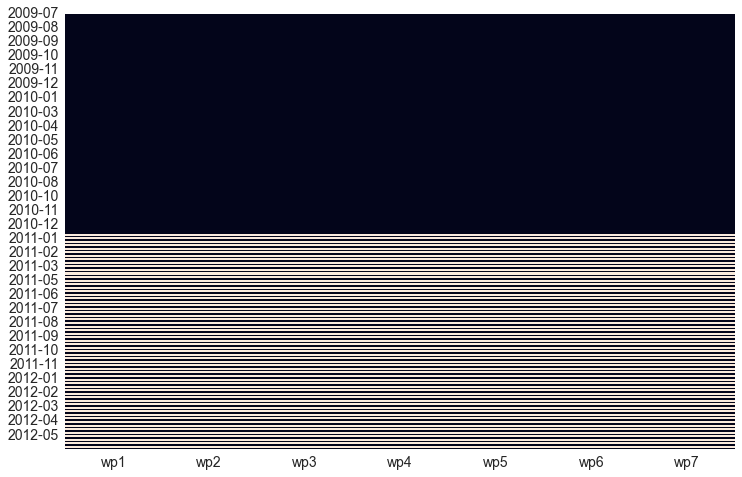

In [7]:
# Plot heatmap of missing data
ALL_TIME = pd.DataFrame(index=pd.date_range(y_train.index[0],y_train.index[-1], freq='H')) 
plt.figure()
# 
plot_data = y_train.join(ALL_TIME, how = 'outer').isna()
plot_data.index = plot_data.index.strftime('%Y-%m')

sns.heatmap(plot_data, cbar = False)  #['2011-06-01':'2011-06-04']

In [8]:
from scipy.special import gamma
from scipy.optimize import fsolve
from scipy import stats
from scipy.stats import linregress

In [9]:
def Weibull_fitter_LS(U,nbins=25,lower=0.5,upper=20):
    hist = np.histogram(U, bins=nbins)
    hist_dist = stats.rv_histogram(hist)
    u=np.linspace(lower,upper,nbins)
    FU = hist_dist.cdf(u)
    y=np.log(np.log(1/(1-FU)))
    x=np.log(u)
    plt.plot(x,y,"o")
    fit=linregress(x,y)
    plt.plot(x,x*fit[0]+fit[1],"r--")
    plt.xlabel("$\ln(U)$")
    plt.ylabel(r"$\ln\left(\ln\left(\frac{1}{1-F(U)}\right)\right)$")
    return fit[0],np.exp(-fit[1]/fit[0])

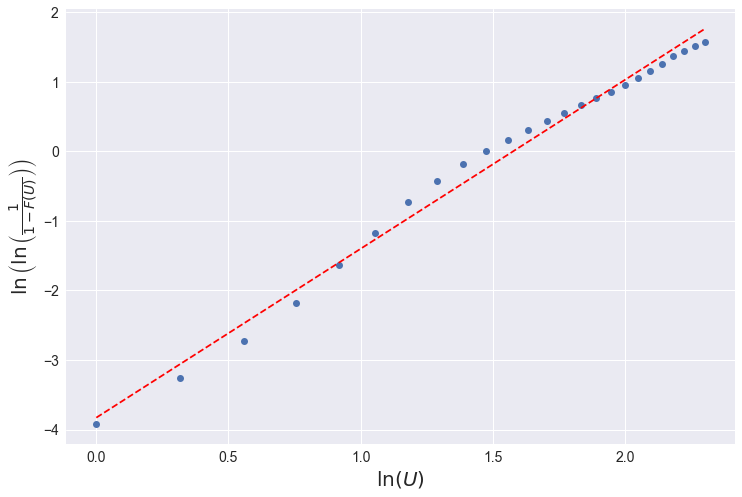

In [10]:
(k_ls,A_ls)=Weibull_fitter_LS(ws,25,1,10)

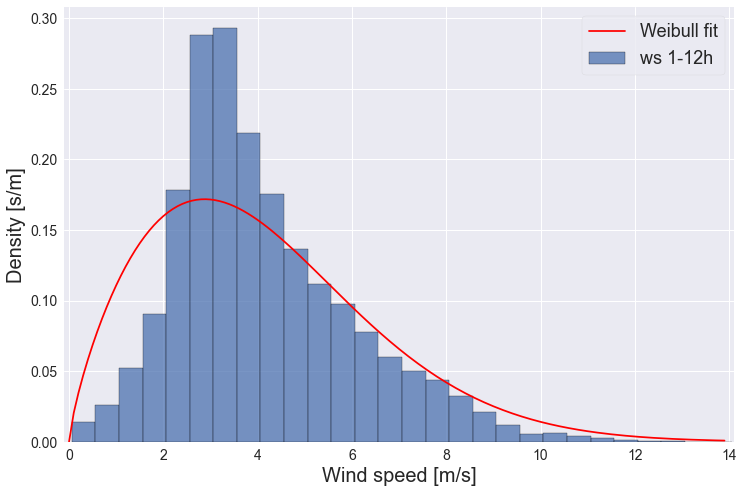

In [11]:
sns.histplot(ws, binwidth = 0.5, stat="density",label="ws 1-12h")
plt.xlabel("Wind speed [m/s]")
plt.ylabel("Density [s/m]")
plt.xlim((-0.1,14.1))
u=np.mean(ws)
u3=np.mean(ws**3)
func = lambda k: gamma(1+3/k)/gamma(1+1/k)-u3/u**3
k=fsolve(func,2)[0]
x = np.arange(0, 14, 0.1)
A=u/gamma(1+1/k)
plt.plot(x, stats.weibull_min.pdf(
                x, c=k, scale=A), '-r', label='Weibull fit')
#plt.plot(x, stats.weibull_min.pdf(
#                x, c=k_ls, scale=A_ls), '-g', label='Weibull fit (LS)')
plt.legend(loc="upper right")





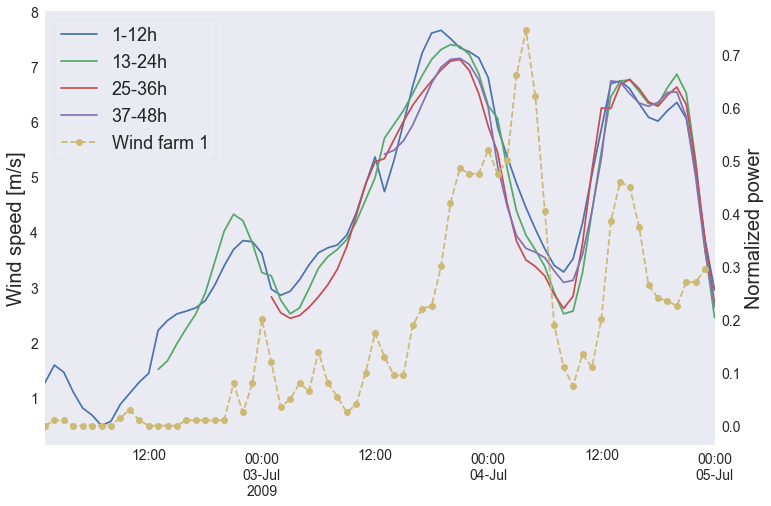

In [12]:
fig,ax=plt.subplots()
x_train.loc[x_train.hors<=12]["2009-07-02 00":"2009-07-04 12"].plot(y="ws",
                                                                    x="time",
                                                                    ax=ax,
                                                                    label="1-12h")
x_train.loc[(x_train.hors>12) & (x_train.hors<=24)]["2009-07-02 00":"2009-07-04 00"].plot(y="ws",
                                                                                          x="time",
                                                                                          ax=ax,
                                                                                          label="13-24h")
x_train.loc[(x_train.hors>24) & (x_train.hors<=36)]["2009-07-02 00":"2009-07-03 12"].plot(y="ws",
                                                                                          x="time",
                                                                                          ax=ax,
                                                                                          label="25-36h")
x_train.loc[(x_train.hors>36) & (x_train.hors<=48)]["2009-07-02 00":"2009-07-03 00"].plot(y="ws",
                                                                                          x="time",
                                                                                          ax=ax,
                                                                                          label="37-48h")
y_train["2009-07-02 01":"2009-07-04"].plot(y="wp1",
                                           secondary_y=True,
                                           ax=ax,
                                           mark_right=False,
                                           style="--o",
                                           label="Wind farm 1")
ax.set_ylabel("Wind speed [m/s]")
ax.right_ax.set_ylabel("Normalized power")
ax.set(xlabel=None)
plt.grid()

# fig,ax=plt.subplots()
# x_train.loc["2009-07-02 00"].plot(y="ws",x="time",ax=ax)
# x_train.loc["2009-07-02 12"].plot(y="ws",x="time",ax=ax)
# x_train.loc["2009-07-03 00"].plot(y="ws",x="time",ax=ax)
# y_train["2009-07-02 01":"2009-07-04"].plot(y="wp1",secondary_y=True,ax=ax,mark_right=False)
# ax.set_ylabel("Wind speed [m/s]")
# ax.right_ax.set_ylabel("Normalized power")
# ax.set(xlabel=None)

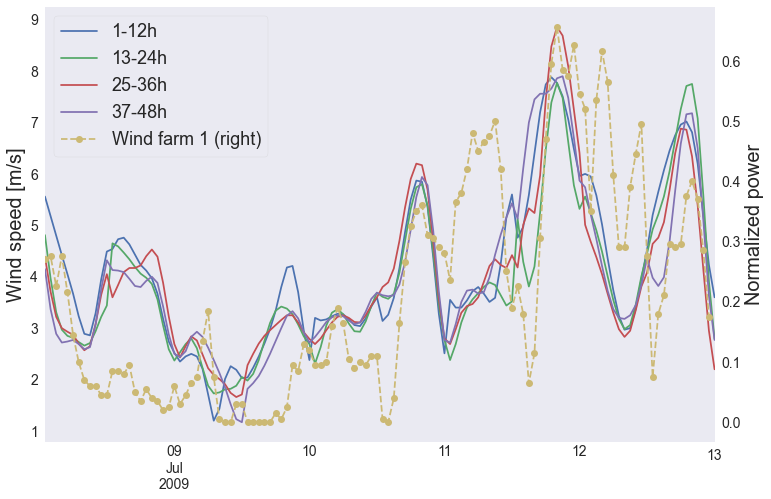

In [16]:
fig,ax=plt.subplots()
x_train.loc[x_train.hors<=12]["2009-07-08 00":"2009-07-12 12"].plot(y="ws",
                                                                    x="time",
                                                                    ax=ax,
                                                                    label="1-12h")
x_train.loc[(x_train.hors>12) & (x_train.hors<=24)]["2009-07-07 12":"2009-07-12 00"].plot(y="ws",
                                                                                          x="time",
                                                                                          ax=ax,
                                                                                          label="13-24h")
x_train.loc[(x_train.hors>24) & (x_train.hors<=36)]["2009-07-07 00":"2009-07-11 12"].plot(y="ws",
                                                                                          x="time",
                                                                                          ax=ax,
                                                                                          label="25-36h")
x_train.loc[(x_train.hors>36) & (x_train.hors<=48)]["2009-07-06 12":"2009-07-11 00"].plot(y="ws",
                                                                                          x="time",
                                                                                          ax=ax,
                                                                                          label="37-48h")
y_train["2009-07-08 01":"2009-07-12"].plot(y="wp1",
                                           secondary_y=True,
                                           ax=ax,
                                           style="--o",
                                           label="Wind farm 1")
ax.set_ylabel("Wind speed [m/s]")
ax.right_ax.set_ylabel("Normalized power")
ax.set(xlabel=None)
plt.grid()

# fig,ax=plt.subplots()
# x_train.loc["2009-07-02 00"].plot(y="ws",x="time",ax=ax)
# x_train.loc["2009-07-02 12"].plot(y="ws",x="time",ax=ax)
# x_train.loc["2009-07-03 00"].plot(y="ws",x="time",ax=ax)
# y_train["2009-07-02 01":"2009-07-04"].plot(y="wp1",secondary_y=True,ax=ax,mark_right=False)
# ax.set_ylabel("Wind speed [m/s]")
# ax.right_ax.set_ylabel("Normalized power")
# ax.set(xlabel=None)

Text(0.5, 0, 'Wind speed (1-12h) [m/s]')

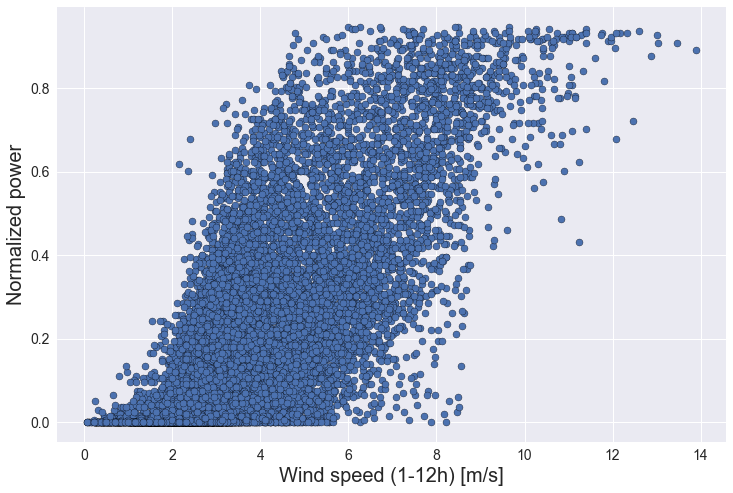

In [14]:
# complete_ts["time"]=complete_ts.index
# plotdat=x_plot.merge(complete_ts,on="time")
# fit_dat=plotdat[plotdat.ws<10]
x_plot=x_train[x_train.hors<=12]
x_plot=x_plot[:'2010-12-31 12']
#polyf=np.polyfit(fit_dat.ws,fit_dat.wp1, 3) 
plt.scatter(x_plot.ws,complete_ts.wp1[1:],edgecolors="k")
#x_dum=np.arange(x_plot.ws.min(),x_plot.ws.max(),1)
#plt.plot(x_dum,np.power(x_dum,3)*polyf[0]+np.power(x_dum,2)*polyf[1]+x_dum*polyf[2]+polyf[3],"--")
plt.ylabel("Normalized power")
plt.xlabel("Wind speed (1-12h) [m/s]")

## Modelling

In [ ]:
class FFNN_LSTM(nn.Module):
    def __init__(self):
        super(FFNN_LSTM, self).__init__()
        # input_size – The number of expected features in the input x
        # hidden_size – The number of features in the hidden state h
        # batch_first = False >>> input prov (seq, batch, feature)

        self.lstm = nn.LSTM(input_size = 1, 
                  hidden_size = 32,#1028,
                     num_layers = 1,
                         batch_first = False)
        

        self.inputLay = nn.Linear(in_features = 16,
                               out_features = 32,#512,
                               bias = True)
        
        self.hidden_layer = nn.Linear(in_features = 32,#512,
                                      out_features = 32,#,512,
                                      bias = True)
        
        self.combined = nn.Linear(in_features= 32+32,#1028+512, 
                        out_features= 32,#512,
                        bias = True) # should be false ?

        self.output_lay = nn.Linear(in_features= 32,#512, 
                        out_features= 1,
                        bias = True) # should be false ?

                 
    def forward(self, pow_seq, for_feat):
        #print(np.shape(x))
        x = torch.permute(pow_seq, (1,0,2) )  # permute batch with sequence 
        #print(np.shape(x))
        x, (h, c) = self.lstm(x)

        x = x[-1] # takes the last hidden state of LSTM
        #print(x)
        #print(np.shape(x))
        # Dense layer
        y = self.inputLay(for_feat)
        y = F.elu(y) # F = nn.Functional
        y = self.hidden_layer(y)
        y = F.elu(y)
        #print(y)
        #print(np.shape(y))
        z = torch.cat( (x,y), dim = 1 )
        #print(np.shape(z))
        z = self.combined(z)
        z = F.elu(z)
        z = self.output_lay(z)

        return z
  
net = FFNN_LSTM()
if torch.cuda.is_available():
    print('##converting network to cuda-enabled')
    net.cuda()

print(net)


In [ ]:
# define validation and training set

batch_size = 128
# input_generator = np.transpose(np.array([y_train.wp1]))

# Note: TimeseriesGenerator end_index is including that index, not excluding it as it is the case in general in Python

training_set = TimeseriesGenerator(input_generator, input_generator, length=length, batch_size=batch_size, shuffle = False, start_index = 0 , end_index = int(len(complete_ts)*0.8)) # 80 percent
validation_set = TimeseriesGenerator(input_generator, input_generator, length=length, batch_size=batch_size, shuffle = False, start_index = int(len(complete_ts)*0.8)+1, end_index = len(complete_ts)-1)

In [ ]:
print(f'The lenght of the validation set: {len(validation_set)}')
print(f'The lenght of the training set: {len(training_set)}')

# define early stopping class 

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

**Training of the LSTM**

In [ ]:
ExelResults = pd.read_excel('Comparison_models_intraday.xlsx', index_col= 0)#, header = None , names = 'Model 1hr 2hr 3hr 4hr 5hr 6hr'.split() )
ExelResults 

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))
ExelResults.filter(like="RMSE").T.set_index(np.arange(1,7)).plot(style='o-',ax=ax)
ax.set_ylabel('RMSE')
ax.legend(loc = 'upper left',ncol=3)
ax.set_ylim(top=0.33)
ax.set_xlabel("Target hour")

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))
ExelResults.filter(like="MAE").T.set_index(np.arange(1,7)).plot(style='o-',ax=ax)
ax.set_ylabel('MAE')
ax.legend(loc = 'upper left',ncol=3)
ax.set_ylim(top=0.23)
ax.set_xlabel("Target hour")

In [ ]:
## 
model = net
model.load_state_dict(torch.load('checkpoint.pt'))

In [ ]:
# Train loop 
criterion = nn.MSELoss() 
optimizer = optim.Adam(net.parameters(),lr=5e-6) # , momentum=0.9

training_loss, validation_loss = [], []  # store loss for each epoch
num_epochs = 15000 # should be tuned

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=1000, verbose=True)

for i in range(num_epochs):
  # Track loss
  epoch_training_loss = 0
  epoch_validation_loss = 0
  net.eval() # EVALUATION mode -> dont use regularization methods
    
  # For each sentence in validation set
  for j,(inputs, targets) in enumerate(validation_set):

    # Convert input to tensor
    inputs_pow = torch.Tensor(inputs)

    # ADD (length-1) hours and not length because the first forecast (index 0) is already for the next hour after the first observation.
    # The forecast in index (length-1) is then after the length first observations.
    # A -1 was added because the training set of forecast has one less value.

    inputs_pred = torch.Tensor(x_train_sectors.iloc[(j*batch_size+length-1+int(len(complete_ts)*0.8)+1-1):((j+1)*batch_size+length-1+int(len(complete_ts)*0.8)+1-1)].values)        
    # print('Inside training loop')
    # print(f'shape of input {np.shape(inputs)}')

    if len(inputs_pow) != batch_size:
      inputs_pred = inputs_pred[:len(inputs_pow)]

    # Convert target to tensor
    targets = torch.Tensor(targets)
    #print(targets)
    # print(f'shape of targets {np.shape(targets)}')

    #Convert targets and inputs to cuda
    if torch.cuda.is_available():
        inputs_pow = Variable(inputs_pow.cuda())
        inputs_pred = Variable(inputs_pred.cuda())
        targets = Variable(targets.cuda())

    # Evaluate the model
    outputs = net(inputs_pow,inputs_pred) 

    # print(f'shape of outputs {np.shape(outputs)}')
    #print(outputs)
    # Compute loss


    loss =  criterion(outputs,targets) 

    if torch.cuda.is_available():
      epoch_validation_loss += loss.cpu().detach().numpy()
    else:
      epoch_validation_loss += loss.detach().numpy() # suma el loss de cada batch, luego se reinicia para proxima epoch


  net.train()

  for j,(inputs, targets) in enumerate(training_set):

    # Convert input to tensor
    inputs_pred = torch.Tensor(x_train_sectors.iloc[(j*batch_size+length-1):((j+1)*batch_size+length-1)].values)
    inputs_pow = torch.Tensor(inputs)
    # print('Inside training loop')
    # print(f'shape of input {np.shape(inputs)}')

    # Convert target to tensor
    targets = torch.Tensor(targets)
    #print(targets)
    # print(f'shape of targets {np.shape(targets)}')

    if len(inputs_pow) != batch_size:
      inputs_pred = inputs_pred[:len(inputs_pow)]

    #Convert targets and inputs to cuda
    if torch.cuda.is_available():
        inputs_pow = Variable(inputs_pow.cuda())
        inputs_pred = Variable(inputs_pred.cuda())
        targets = Variable(targets.cuda())

    # Evaluate the model
    outputs = net(inputs_pow,inputs_pred)      
    # print(f'shape of outputs {np.shape(outputs)}')
    #print(outputs)
    # Compute loss
    loss =  criterion(outputs,targets)

    optimizer.zero_grad() # zero the gradients
    loss.backward()       # calculate gradients for current step
    optimizer.step()      # update the weights 

    if torch.cuda.is_available():
      epoch_training_loss += loss.cpu().detach().numpy()
    else:
      epoch_training_loss += loss.detach().numpy()

        

  # Save loss for plot
  avg_train_loss=np.sqrt(epoch_training_loss/(len(training_set)))
  avg_valid_loss=np.sqrt(epoch_validation_loss/(len(validation_set)))
  training_loss.append(avg_train_loss)
  validation_loss.append(avg_valid_loss)       
  print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

  # early_stopping needs the validation loss to check if it has decresed, 
  # and if it has, it will make a checkpoint of the current model
  early_stopping(avg_valid_loss, net)
    
  if early_stopping.early_stop:
    print("Early stopping")
    break


In [ ]:
# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, epoch, validation_loss)
plt.xlabel('Epoch'), plt.ylabel('RMSE')
plt.show()

**Evaluation of LSTM 1 to 6 hours ahead, on validation set**

In [ ]:
# Define the validation set as one sequence
validation_power = input_generator[int(len(input_generator)*0.8)+1 : int(len(input_generator))-1]
validation_forecast_feats  = x_train_sectors.iloc[(length-1+int(len(complete_ts)*0.8)+1):len(x_train_sectors)]

In [ ]:
# Define slices of 24h inputs and corresponding targets 1, 2 and 3 hours ahead
p_inputs = []
p_targets1h = []
p_targets2h = []
p_targets3h = []
p_targets4h = []
p_targets5h = []
p_targets6h = []

ff_inputs1h = []
ff_inputs2h = []
ff_inputs3h = []
ff_inputs4h = []
ff_inputs5h = []
ff_inputs6h = []

for i in range(len(validation_power)-(length+5)):
  ff_inputs1h.append(validation_forecast_feats.iloc[i].values)
  ff_inputs2h.append(validation_forecast_feats.iloc[i+1].values)
  ff_inputs3h.append(validation_forecast_feats.iloc[i+2].values)
  ff_inputs4h.append(validation_forecast_feats.iloc[i+3].values)
  ff_inputs5h.append(validation_forecast_feats.iloc[i+4].values)
  ff_inputs6h.append(validation_forecast_feats.iloc[i+5].values)


  p_inputs.append(validation_power[i:i+length])
  p_targets1h.append(validation_power[i+length])
  p_targets2h.append(validation_power[i+length+1])
  p_targets3h.append(validation_power[i+length+2])
  p_targets4h.append(validation_power[i+length+3])
  p_targets5h.append(validation_power[i+length+4])
  p_targets6h.append(validation_power[i+length+5])

In [ ]:
# x_train_sectors["time"]=x_train_update.time.values   # JUST FOR TESTING THE DATE IS APPROPIATE, dont delete

In [ ]:
# Forecasting 1, 2 and 3 hours ahead

# Back on CPU
net.to('cpu')

# Store predictions and errors
pred_1h = []
err_1h = []
pred_2h = []
err_2h = []
pred_3h = []
err_3h = []
pred_4h = []
err_4h = []
pred_5h = []
err_5h = []
pred_6h = []
err_6h = []

# Loop over the sequences of valid data
for seq in range(len(p_inputs)):

    # Define past value for the 1h forecast
    past = p_inputs[seq]
    ff = ff_inputs1h[seq]

    # Take output for the past sequence
    pred_1h.append(net(torch.Tensor([past]), torch.Tensor([ff]) ).item())
    err_1h.append(pred_1h[-1]-p_targets1h[seq][0])

    # Repeat with prediction 2 hours ahead actualizing the past values
    past = np.append(past,[[pred_1h[-1]]],0)
    ff = ff_inputs2h[seq]
    pred_2h.append(net(torch.Tensor([past]), torch.Tensor([ff]) ).item())
    err_2h.append(pred_2h[-1]-p_targets2h[seq][0])

    # Repeat with prediction 3 hours ahead
    past = np.append(past,[[pred_2h[-1]]],0)
    ff = ff_inputs3h[seq]
    pred_3h.append(net(torch.Tensor([past]), torch.Tensor([ff]) ).item())
    err_3h.append(pred_3h[-1]-p_targets3h[seq][0])

    # Repeat with prediction 4 hours ahead
    past = np.append(past,[[pred_3h[-1]]],0)
    ff = ff_inputs4h[seq]
    pred_4h.append(net(torch.Tensor([past]), torch.Tensor([ff]) ).item())
    err_4h.append(pred_4h[-1]-p_targets4h[seq][0])

    # Repeat with prediction 5 hours ahead
    past = np.append(past,[[pred_4h[-1]]],0)
    ff = ff_inputs5h[seq]
    pred_5h.append(net(torch.Tensor([past]), torch.Tensor([ff]) ).item())
    err_5h.append(pred_5h[-1]-p_targets5h[seq][0])

    # Repeat with prediction 6 hours ahead
    past = np.append(past,[[pred_5h[-1]]],0)
    ff = ff_inputs6h[seq]
    pred_6h.append(net(torch.Tensor([past]), torch.Tensor([ff]) ).item())
    err_6h.append(pred_6h[-1]-p_targets6h[seq][0])

    if seq % 100 == 0:
      print(f'step {seq+1}, RMSE 1h: {np.sqrt(stat.mean(err_1h[n]**2 for n in range(len(err_1h))))}, RMSE 2h: {np.sqrt(stat.mean(err_2h[n]**2 for n in range(len(err_2h))))}, RMSE 3h: {np.sqrt(stat.mean(err_3h[n]**2 for n in range(len(err_3h))))}, RMSE 4h: {np.sqrt(stat.mean(err_4h[n]**2 for n in range(len(err_4h))))}, RMSE 5h: {np.sqrt(stat.mean(err_5h[n]**2 for n in range(len(err_5h))))}, RMSE 6h: {np.sqrt(stat.mean(err_6h[n]**2 for n in range(len(err_6h))))}')

In [ ]:
price=140 # euro/MWh
scale=100 #MW

Rev_perf_1h=np.sum(scale*np.squeeze(p_targets1h)*price)
print("Perfect revenue {} MEuro".format(np.round(Rev_perf_1h/1e6,4)))

Rev_3m_1h=np.sum(np.squeeze(p_targets1h)-np.abs(err_1h))*price*scale #Euro
print("The revenue of the best model 1h ahead is {} MEuro".format(np.round(Rev_3m_1h/1e6,2)))

Rev_3m_6h=np.sum(np.squeeze(p_targets6h)-np.abs(err_6h))*price*scale #Euro
print("The revenue of the best model 6h ahead is {} MEuro".format(np.round(Rev_3m_6h/1e6,2)))


In [ ]:
plt.scatter(p_targets1h , pred_1h)
from sklearn.metrics import r2_score
from scipy.stats import linregress
fit1h=linregress(np.reshape(np.array(p_targets1h), (len(p_targets1h,))), pred_1h)
fit6h=linregress(np.reshape(np.array(p_targets6h), (len(p_targets6h,))), pred_6h)

In [ ]:
?linregress

In [ ]:
# text box properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
loc=(0.1,0.95)
# begin subplot
fig=plt.figure()
ax=fig.add_subplot(1,2,1)
ax.scatter(p_targets1h , pred_1h ,edgecolors="k") # change
textstr = r'$R^2=$%.2f%s' % (fit1h[2]**2*100,"%")
y=np.reshape(np.array(p_targets1h), (len(p_targets1h,)))
ax.plot(y,y*fit1h[0]+fit1h[1],"r--")
ax.text(loc[0],loc[1], textstr, transform=ax.transAxes,
  fontsize=16, verticalalignment='top', bbox=props)
ax.set_xlabel("Targets [1h]")
ax.set_ylabel("Power Predictions [1h]")

ax=fig.add_subplot(1,2,2)
ax.scatter(p_targets6h , pred_6h ,edgecolors="k") # change
textstr = r'$R^2=$%.2f%s' % (fit6h[2]**2*100,"%")
y=np.reshape(np.array(p_targets6h), (len(p_targets6h,)))
ax.plot(y,y*fit6h[0]+fit6h[1],"r--")
ax.text(loc[0],loc[1], textstr, transform=ax.transAxes,
  fontsize=16, verticalalignment='top', bbox=props)
ax.set_xlabel("Targets [6h]")
ax.set_ylabel("Power Predictions [6h]")
plt.show()
  #NEXT SUPLOT...


In [ ]:
import seaborn as sns

In [ ]:
residuals6h = np.reshape(np.array(p_targets6h), (len(p_targets6h,)))   -      np.array(pred_6h)
residuals1h = np.reshape(np.array(p_targets1h), (len(p_targets1h,)))   -      np.array(pred_1h)

In [ ]:
sns.histplot(residuals6h, bins = 50)

In [ ]:
sns.histplot(residuals1h, bins = 50)

In [ ]:
# Estimation of confidence intervals:
RMSE_1h = np.sqrt(stat.mean(err_1h[n]**2 for n in range(len(err_1h))))
RMSE_2h = np.sqrt(stat.mean(err_2h[n]**2 for n in range(len(err_2h))))
RMSE_3h = np.sqrt(stat.mean(err_3h[n]**2 for n in range(len(err_3h))))
CI_1h = [norm.ppf(0.025)*RMSE_1h,norm.ppf(0.975)*RMSE_1h]
CI_2h = [norm.ppf(0.025)*RMSE_2h,norm.ppf(0.975)*RMSE_2h]
CI_3h = [norm.ppf(0.025)*RMSE_3h,norm.ppf(0.975)*RMSE_3h]
print(f'Confidence interval 1h: {CI_1h}')
print(f'Confidence interval 2h: {CI_2h}')
print(f'Confidence interval 3h: {CI_3h}')

Persistent

In [ ]:
# Forecasting 1, 2 and 3 hours ahead

# Back on CPU
net.to('cpu')

# Store predictions and errors
pred_1h = []
err_1h = []
pred_2h = []
err_2h = []
pred_3h = []
err_3h = []
pred_4h = []
err_4h = []
pred_5h = []
err_5h = []
pred_6h = []
err_6h = []

# Loop over the sequences of valid data
for seq in range(1,len(p_inputs)):  #len(p_inputs)


    # Take output for the past sequence
#    pred_1h.append(net(torch.Tensor([past]), torch.Tensor([ff]) ).item())
    err_1h.append(p_targets1h[seq][0]-p_targets1h[seq-1][0])
    # print(f'True value for 1h : {p_targets1h[seq][0]}')
    # print(f'Prediction for 1h : {p_targets1h[seq-1][0]}')

    # Repeat with prediction 2 hours ahead actualizing the past values

    err_2h.append(p_targets2h[seq][0]-p_targets1h[seq-1][0])

    # print(f'True value for 2h : {p_targets2h[seq][0]}')
    # print(f'Prediction for 2h : {p_targets1h[seq-1][0]}')

    # Repeat with prediction 3 hours ahead
    err_3h.append(p_targets3h[seq][0]-p_targets1h[seq-1][0])

    # print(f'True value for 3h : {p_targets3h[seq][0]}')
    # print(f'Prediction for 3h : {p_targets1h[seq-1][0]}')

    # Repeat with prediction 4 hours ahead
    err_4h.append(p_targets4h[seq][0]-p_targets1h[seq-1][0])

    # Repeat with prediction 5 hours ahead

    err_5h.append(p_targets5h[seq][0]-p_targets1h[seq-1][0])

    # Repeat with prediction 6 hours ahead

    err_6h.append(p_targets6h[seq][0]-p_targets1h[seq-1][0])

    if seq % 100 == 0:
      print(f'step {seq+1}, RMSE 1h: {np.sqrt(stat.mean(err_1h[n]**2 for n in range(len(err_1h))))}, RMSE 2h: {np.sqrt(stat.mean(err_2h[n]**2 for n in range(len(err_2h))))}, RMSE 3h: {np.sqrt(stat.mean(err_3h[n]**2 for n in range(len(err_3h))))}, RMSE 4h: {np.sqrt(stat.mean(err_4h[n]**2 for n in range(len(err_4h))))}, RMSE 5h: {np.sqrt(stat.mean(err_5h[n]**2 for n in range(len(err_5h))))}, RMSE 6h: {np.sqrt(stat.mean(err_6h[n]**2 for n in range(len(err_6h))))}')

In [ ]:
price=140 # euro/MWh
scale=100 #MW
Rev_3m_1h=np.sum(np.squeeze(p_targets1h)[1:]-np.abs(err_1h))*price*scale #Euro
print("The revenue of the baseline 1h ahead is {} MEuro".format(np.round(Rev_3m_1h/1e6,2)))

Rev_3m_6h=np.sum(np.squeeze(p_targets6h)[1:]-np.abs(err_6h))*price*scale #Euro
print("The revenue of the baseline 6h ahead is {} MEuro".format(np.round(Rev_3m_6h/1e6,2)))


### revenue plot

In [3]:
from glob import glob

In [4]:
glob("../../*")

['../..\\Articles',
 '../..\\benchmark.csv',
 '../..\\Comparison_models_intraday.xlsx',
 '../..\\Economical_Results.xlsx',
 '../..\\Kaggle Data',
 '../..\\Models',
 '../..\\README.md',
 '../..\\Results.xlsx',
 '../..\\test.csv',
 '../..\\train.csv']

In [5]:
?pd.read_excel

In [19]:
rev_per = pd.read_excel('../../Economical_Results.xlsx', index_col= 0,sheet_name=1)#, header = None , names = 'Model 1hr 2hr 3hr 4hr 5hr 6hr'.split() )
rev_M3 = pd.read_excel('../../Economical_Results.xlsx', index_col= 0,sheet_name=0)

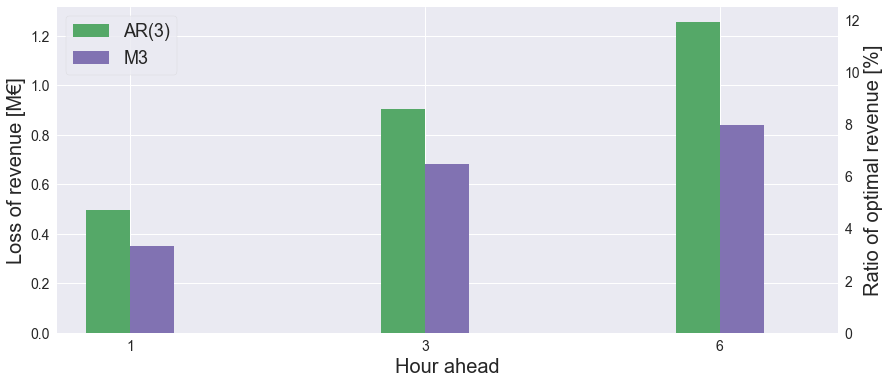

In [29]:
width=0.15
colum="Loss"#"Final revenue"
ax=rev_per[[colum]].plot.bar(position=1,width=width,color='#55A868',figsize=[14,6])
ax=rev_M3[[colum]].plot.bar(position=0,width=width,ax=ax,color='#8172B2',rot=0)

ax.legend(["AR(3)","M3"],loc="upper left");

ax.set_xlabel("Hour ahead")
ax.set_ylabel("Loss of revenue [M€]")

ax2 = ax.twinx()
ax2.set_ylim(top=12.5)
ax2.set_ylabel('Ratio of optimal revenue [%]')
#plt.grid()

plt.grid()



In [16]:
sns.color_palette(as_cmap=1)

['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974', '#64B5CD']

In [21]:
1-rev_per.filter(like="Performance")

,Performance ratio
Hours,
1,0.047528
3,0.086934
6,0.120573


In [31]:
1-rev_M3.filter(like="Performance")

,Performance ratio
Hours,
1,0.034080
3,0.066212
6,0.081792
